# Gallery

In this notebook we show different types of queries and how their response look like.

## Content

- [Count water and vegetation presence](#Count-water-and-vegetation-presence)
- [Cloud-free composite](#Cloud-free-composite)
- [Land cover map](#Land-cover-map)
- [Cloud and snow cover maps](#Cloud-and-snow-cover-maps)
- [Semantic content based image retrieval](#Semantic-content-based-image-retrieval)
- [Parcel statistics](#Parcel-statistics)
- [Seasonal aggregates](#Seasonal-aggregates)

## Prepare

Import the semantique package:

In [1]:
import semantique as sq

Import the demo factbase format:

In [2]:
from demo_factbase import Demo

Import other packages we will use in this demo:

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json

We will create the query recipes on-the-fly in each example. The other components, however, we construct in advance. In some examples we might change or extend them a bit. See the [Intro notebook](intro.ipynb) for details.

In [4]:
# Ontology.
with open("files/ontology.json", "r") as file:
    ontology = sq.ontology.Semantique(json.load(file))

# Factbase.
with open("files/factbase.json", "r") as file:
    factbase = Demo(json.load(file), src = "files/resources.zip")

# Extent.
space = sq.SpatialExtent(gpd.read_file("files/footprint.geojson"))
time = sq.TemporalExtent("2019-01-01", "2020-12-31")

# Additional configuration.
config = {"output_crs": 3035, "output_tz": "UTC", "spatial_resolution": [-10, 10]}

## Count water and vegetation presence

First, we count for each location in our spatial extent how many times during our temporal extent a certain semantic concept (in this example we use water and vegetation) was observed.

Then, we count for each timestamp at which observations were made during our temporal extent at how many locations in our spatial extent these concepts were observed.

In [5]:
recipe = sq.QueryRecipe()

recipe["water_count_time"] = sq.entity("water").reduce("time", "count")
recipe["vegetation_count_time"] = sq.entity("vegetation").reduce("time", "count")
recipe["water_count_space"] = sq.entity("water").reduce("space", "count")
recipe["vegetation_count_space"] = sq.entity("vegetation").reduce("space", "count")

response = recipe.execute(factbase, ontology, space, time, **config)

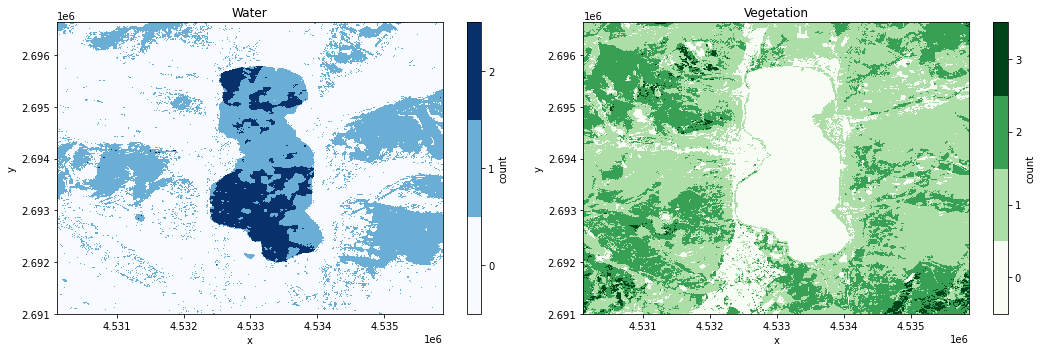

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

water_count = response["water_count_time"].unstack()
values = list(range(int(np.nanmin(water_count)), int(np.nanmax(water_count)) + 1))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = plt.cm.Blues
water_count.plot(ax = ax1, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "count"})
ax1.set_title("Water")

vegetation_count = response["vegetation_count_time"].unstack()
values = list(range(int(np.nanmin(vegetation_count)), int(np.nanmax(vegetation_count)) + 1))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = plt.cm.Greens
vegetation_count.plot(ax = ax2, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "count"})
ax2.set_title("Vegetation")

plt.tight_layout()
plt.draw()

In [7]:
water_count_df = response["water_count_space"].sq.drop_non_dimension_coords().to_dataframe()
vegetation_count_df = response["vegetation_count_space"].sq.drop_non_dimension_coords().to_dataframe()
water_count_df.join(vegetation_count_df, on = "time")

,water_count_space,vegetation_count_space
time,,
2019-12-15 10:17:33.408715,0.0,6045.0
2020-09-05 10:17:43.167942,44804.0,243234.0
2020-12-19 10:17:34.610661,78607.0,89174.0


## Cloud-free composite

In [8]:
recipe = sq.QueryRecipe()

red_band = sq.reflectance("s2_band04")
green_band = sq.reflectance("s2_band03")
blue_band = sq.reflectance("s2_band02")

recipe["composite"] = sq.collection(red_band, green_band, blue_band).\
    filter(sq.entity("cloud").evaluate("invert")).\
    reduce("time", "median").\
    concatenate("band")

response = recipe.execute(factbase, ontology, space, time, **config)

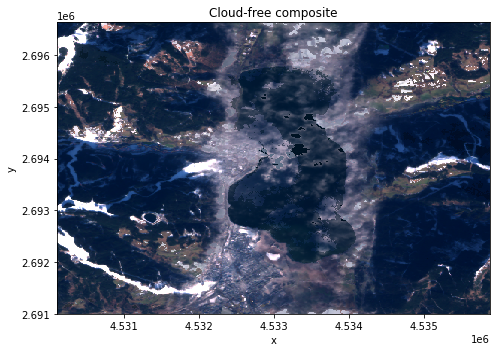

In [9]:
f, ax = plt.subplots(1, figsize = (7, 5))

composite = response["composite"].unstack()
composite.plot.imshow(x = "x", y = "y", rgb = "band", robust = True)
ax.set_title("Cloud-free composite")

plt.tight_layout()
plt.draw()

## Land cover map

Mapping for each location in space the most often observed semantic concept over time.

In [10]:
recipe = sq.QueryRecipe()

recipe["land_cover"] = sq.collection(sq.entity("water"), sq.entity("vegetation"), sq.entity("builtup")).\
    compose().\
    reduce("time", "mode")

response = recipe.execute(factbase, ontology, space, time, **config)

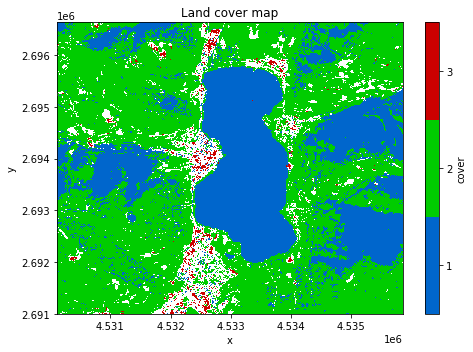

In [11]:
f, ax = plt.subplots(1, figsize = (7, 5))

land_cover = response["land_cover"].unstack()
values = [1, 2, 3]
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = ["#0066CC", "#00CC00", "#CC0000"]
land_cover.plot(ax = ax, levels = levels, colors = colors, cbar_kwargs = {"ticks": values, "label": "cover"})
ax.set_title("Land cover map")

plt.tight_layout()
plt.draw()

## Cloud and snow cover maps

Mapping for each location in space the percentages of times repsectively cloud and snow were observed there.

In [12]:
recipe = sq.QueryRecipe()

recipe["cloud_cover"] = sq.entity("cloud").\
    reduce("time", "percentage")

recipe["snow_cover"] = sq.entity("snow").\
    reduce("time", "percentage")

response = recipe.execute(factbase, ontology, space, time, **config)

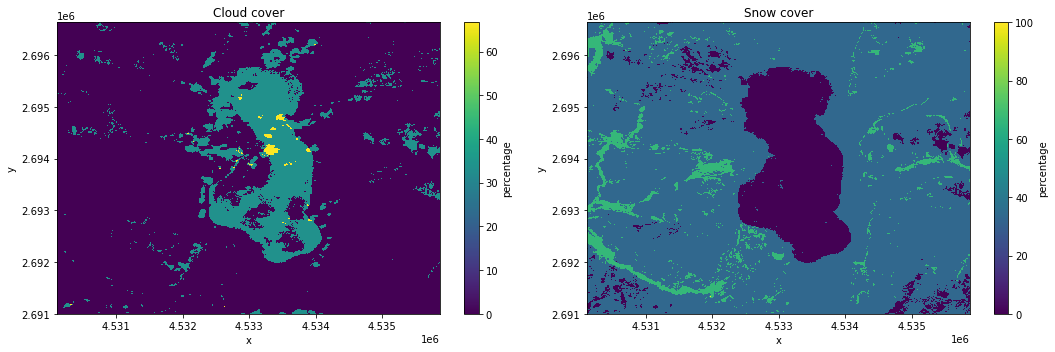

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

cloud_cover = response["cloud_cover"].unstack()
cloud_cover.plot(ax = ax1, cbar_kwargs = {"label": "percentage"})
ax1.set_title("Cloud cover")

snow_cover = response["snow_cover"].unstack()
snow_cover.plot(ax = ax2, cbar_kwargs = {"label": "percentage"})
ax2.set_title("Snow cover")

plt.tight_layout()
plt.draw()

## Semantic content based image retrieval

Check for each image if it has a cloud cover less than 10 percent.

In [14]:
recipe = sq.QueryRecipe()

recipe["cloud_free_images"] = sq.entity("cloud").\
    reduce("space", "percentage").\
    evaluate("less", 10)

response = recipe.execute(factbase, ontology, space, time, **config)

In [15]:
response["cloud_free_images"].sq.drop_non_dimension_coords().astype("bool").to_dataframe()

,cloud_free_images
time,
2019-12-15 10:17:33.408715,False
2020-09-05 10:17:43.167942,True
2020-12-19 10:17:34.610661,True


## Parcel statistics

Using a spatial extent that consists of multiple non-overlapping spatial features, calculate the average water count over time per spatial feature.

In [8]:
parcels = sq.SpatialExtent(gpd.read_file("files/parcels.geojson"))

recipe = sq.QueryRecipe()

recipe["avg_water_count_per_parcel"] = sq.entity("water").\
    reduce("time", "count").\
    groupby(sq.self().extract("space", "feature")).\
    reduce("space", "mean").\
    concatenate("parcel")

response = recipe.execute(factbase, ontology, parcels, time, **config)

In [9]:
df = response["avg_water_count_per_parcel"].sq.drop_non_dimension_coords().to_dataframe()
df

,avg_water_count_per_parcel
parcel,
1.0,0.815466
2.0,1.328767


In [18]:
geodf = parcels._geodf
geodf["avg_water_count"] = response["avg_water_count_per_parcel"].values
parcels._geodf.to_crs(4326).explore(column = "avg_water_count", tiles = "CartoDB positron")

## Seasonal aggregates

We create a water count map for each season in the data separately. We use the built-in "season" component of the time dimension, which defines seasons as: 1 = December, January, February; 2 = March, April, May; 3 = June, July, August; 4 = September, October, November.

In [10]:
recipe = sq.QueryRecipe()

recipe["water_count_per_season"] = sq.entity("water").\
    groupby(sq.self().extract("time", "season")).\
    reduce("time", "count").\
    concatenate("season")

response = recipe.execute(factbase, ontology, space, time, **config)

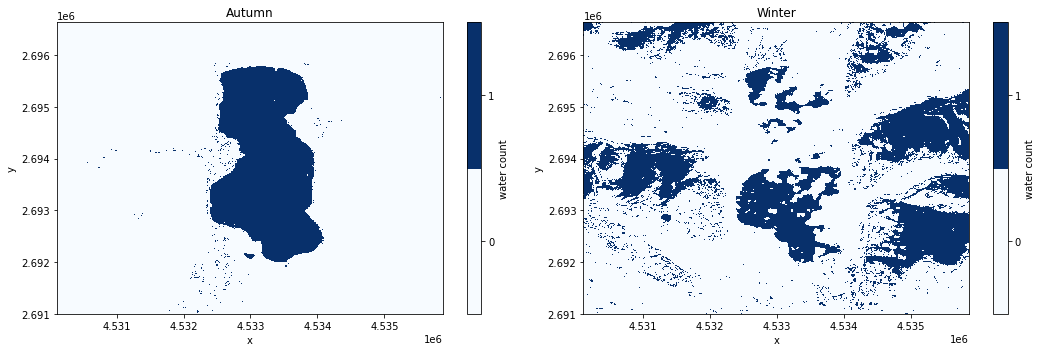

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

water_count_per_season = response["water_count_per_season"].unstack()
values = list(range(int(np.nanmin(water_count_per_season)), int(np.nanmax(water_count_per_season)) + 1))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = plt.cm.Blues

autumn = water_count_per_season.sel(season = 4)
autumn.plot(ax = ax1, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "water count"})
ax1.set_title("Autumn")

winter = water_count_per_season.sel(season = 1)
winter.plot(ax = ax2, levels = levels, cmap = colors, cbar_kwargs = {"ticks": values, "label": "water count"})
ax2.set_title("Winter")

plt.tight_layout()
plt.draw()